In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats

In [ ]:
data = pd.read_csv(r"/content/drive/My Drive/SITesting/603.bwaves_s_real_data_tf.csv")
print(data)

      cpu_clock     isa  l1_size  l2_size  l3_size  num-cpus   mem_type  \
0           2.7  X86_64       32     1024    49152        36  PC4-2666V   
1           2.1  X86_64       32     1024    77824        56  PC4-2666V   
2           2.5  X86_64       32     1024    77824        56  PC4-2666V   
3           3.0  X86_64       32     1024    49152        36  PC4-2666V   
4           2.7  X86_64       32     1024    49152        36  PC4-2666V   
...         ...     ...      ...      ...      ...       ...        ...   
1981        2.1  X86_64       32     1024    71680        52  PC4-2666V   
1982        2.1  X86_64       32     1024   155648       112  PC4-2666V   
1983        3.0  X86_64       32     1024    98304        72  PC4-2666V   
1984        2.5  X86_64       32     1024   155648       112  PC4-2666V   
1985        2.1  X86_64       32     1024   143360       104  PC4-2666V   

      mem_clock  mem_size  
0          2666       768  
1          2666       768  
2          2666

In [ ]:
for i in data.columns:
  print(i,data[i].unique())

cpu_clock [2.7  2.1  2.5  3.   3.5  2.4  3.4  2.   2.6  3.2  2.2  2.3  3.8  3.7
 3.3  3.6  1.9  2.25 2.9  2.8  4.   3.9  3.1  2.35 2.45 2.95 2.65 2.75
 2.85 1.7  1.8 ]
isa ['X86_64']
l1_size [32 64]
l2_size [1024  256  512]
l3_size [ 49152  77824  55296  38912  26624  45056  12288   8192  32768  61440
  22528  16384 262144  71680 131072 524288 393216 196608  65536  67584
 122880 116736 110592  98304  73728  36864  86016  24576 143360 155648
  53248 135168  90112  79872  30720   2048   6144   4096  35840  27648
  18432  15360  39936  43008 233472 311296 983040 112640]
num-cpus [ 36  56  16  40  12  24  20  28  32   6   4  44  64  48   8 128  52  96
  80  76 112  72 104  88   2  10  18 168 224 384]
mem_type ['PC4-2666V' 'PC4-2933Y' 'PC4-3200AA' 'PC4-2933V' '0' 'PC4-2400T']
mem_clock [2666 2933 3200    0 2400]
mem_size [ 768  384  192   64  256  512 1024 1536 2048  176   96  128  320 2304
 3072   32 4096]


In [ ]:
data=data.drop(['isa','mem_type','l1_size'],axis=1)
print(data)

      cpu_clock  l2_size  l3_size  num-cpus  mem_clock  mem_size
0           2.7     1024    49152        36       2666       768
1           2.1     1024    77824        56       2666       768
2           2.5     1024    77824        56       2666       384
3           3.0     1024    49152        36       2666       384
4           2.7     1024    49152        36       2666       384
...         ...      ...      ...       ...        ...       ...
1981        2.1     1024    71680        52       2666       192
1982        2.1     1024   155648       112       2666       768
1983        3.0     1024    98304        72       2666       768
1984        2.5     1024   155648       112       2666       768
1985        2.1     1024   143360       104       2666       768

[1986 rows x 6 columns]


In [ ]:
mms = MinMaxScaler()
data_rescaled = mms.fit_transform(data)
data_rescaled

array([[0.43478261, 1.        , 0.0480167 , 0.08900524, 0.833125  ,
        0.18110236],
       [0.17391304, 1.        , 0.07724426, 0.14136126, 0.833125  ,
        0.18110236],
       [0.34782609, 1.        , 0.07724426, 0.14136126, 0.833125  ,
        0.08661417],
       ...,
       [0.56521739, 1.        , 0.09812109, 0.18324607, 0.833125  ,
        0.18110236],
       [0.34782609, 1.        , 0.1565762 , 0.28795812, 0.833125  ,
        0.18110236],
       [0.17391304, 1.        , 0.1440501 , 0.26701571, 0.833125  ,
        0.18110236]])

In [ ]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model

In [ ]:
latent_dim = 50
generator = build_generator(data_rescaled.shape[1], latent_dim)

In [ ]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [ ]:
def build_discriminator(inputs_n):
	model = Sequential()
	model.add(Dense(128,  kernel_initializer = "he_uniform", input_dim = inputs_n))
	model.add(LeakyReLU(0.2))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

In [ ]:
discriminator = build_discriminator(data_rescaled.shape[1])

In [ ]:
def build_gan(generator, discriminator):
	discriminator.trainable = False
	# connect generator and dicriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	model.compile(loss = "binary_crossentropy", optimizer = optimizer)
	return model

In [ ]:
gan = build_gan(generator, discriminator)

In [ ]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Epoch: 200 [Generator loss: 1.564654] [Discriminator loss: 0.555368]
Epoch: 400 [Generator loss: 0.793416] [Discriminator loss: 0.683689]
Epoch: 600 [Generator loss: 0.689853] [Discriminator loss: 0.688410]
Epoch: 800 [Generator loss: 0.712936] [Discriminator loss: 0.680428]
Epoch: 1000 [Generator loss: 0.711914] [Discriminator loss: 0.685659]
Epoch: 1200 [Generator loss: 0.725543] [Discriminator loss: 0.674657]
Epoch: 1400 [Generator loss: 0.730952] [Discriminator loss: 0.684092]
Epoch: 1600 [Generator loss: 0.729746] [Discriminator loss: 0.683994]
Epoch: 1800 [Generator loss: 0.733962] [Discriminator loss: 0.677853]
Epoch: 2000 [Generator loss: 0.737531] [Discriminator loss: 0.680619]


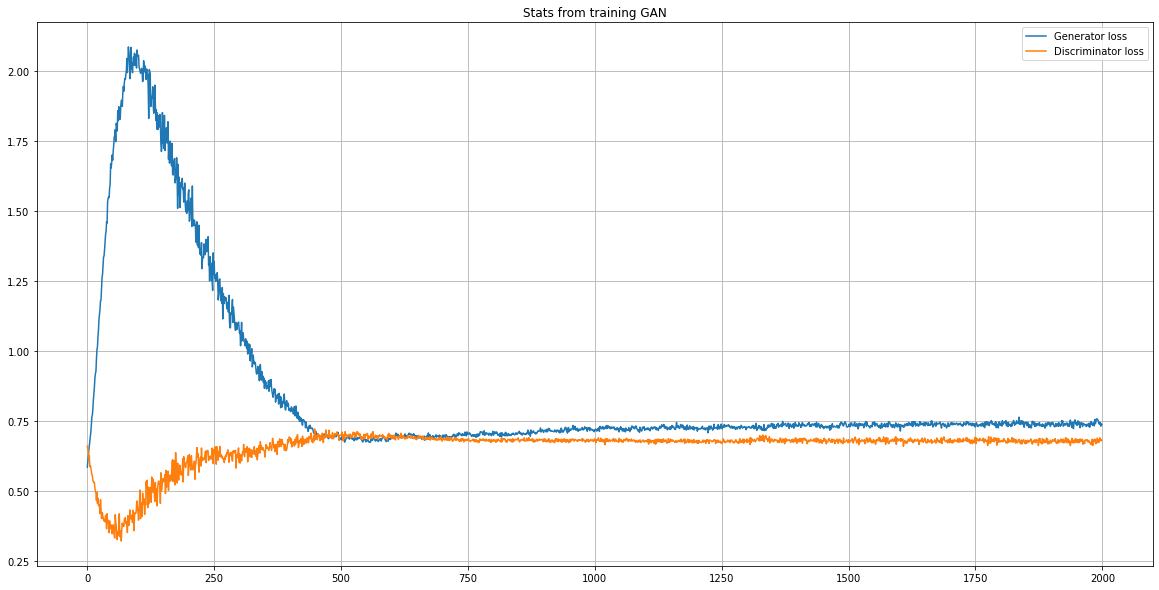

In [ ]:
# n_eval=after that value we will see losses
train(gan, generator, discriminator, data_rescaled, latent_dim, n_epochs = 2000, n_batch = 250, n_eval = 200)

In [ ]:
noise = np.random.normal(0, 1, (1000, latent_dim))
generated_numerical_data = generator.predict(noise)
generated_numerical_data

array([[2.2717017e-01, 9.6817750e-01, 7.1134955e-02, 1.4529714e-01,
        9.0422320e-01, 3.3952659e-01],
       [9.4324088e-01, 2.6423514e-02, 5.2992404e-03, 1.9237399e-04,
        9.9912453e-01, 4.1775405e-03],
       [1.7945734e-01, 9.6979839e-01, 1.0720986e-01, 3.7366566e-01,
        8.7522161e-01, 3.2096946e-01],
       ...,
       [9.8513460e-01, 3.8686395e-04, 5.3796977e-02, 4.5299530e-04,
        9.9998248e-01, 2.2394866e-02],
       [3.9524782e-01, 9.9531800e-01, 1.3616562e-02, 9.7047091e-03,
        6.6546208e-01, 7.5543642e-02],
       [1.0403755e-01, 9.9203110e-01, 3.8187921e-02, 5.4254115e-02,
        8.9391106e-01, 9.4061136e-02]], dtype=float32)

In [ ]:
generated_numerical_data = mms.inverse_transform(generated_numerical_data)
gen_df = pd.DataFrame(data = generated_numerical_data, columns = data.columns)
gen_df

,cpu_clock,l2_size,l3_size,num-cpus,mem_clock,mem_size
0,2.222492,999.560303,71830.820312,57.503506,2893.514160,1411.836060
1,3.869454,276.293274,7246.512207,2.073487,3197.198486,48.977524
2,2.112752,1000.805176,107220.015625,144.740280,2800.709229,1336.419922
3,3.206370,1021.891235,28387.679688,23.805300,2652.872559,237.478973
4,3.479608,936.963501,88782.757812,9.348595,2728.420166,757.459717
...,...,...,...,...,...,...
995,2.103511,1010.253906,83180.757812,58.780003,2891.217773,963.539795
996,2.010902,696.612244,271817.968750,45.017696,3152.494873,728.959473
997,3.965809,256.297119,54822.402344,2.173044,3199.943848,123.012733
998,2.609070,1020.404175,15405.738281,5.707199,2129.478760,339.009369


In [ ]:
col=[]

for column in gen_df.columns:
  col.append(column)

for column in col[1:]:
  gen_df[column]=gen_df[column].apply(np.round)

print(gen_df)

     cpu_clock  l2_size   l3_size  num-cpus  mem_clock  mem_size
0     2.222492   1000.0   71831.0      58.0     2894.0    1412.0
1     3.869454    276.0    7247.0       2.0     3197.0      49.0
2     2.112752   1001.0  107220.0     145.0     2801.0    1336.0
3     3.206370   1022.0   28388.0      24.0     2653.0     237.0
4     3.479608    937.0   88783.0       9.0     2728.0     757.0
..         ...      ...       ...       ...        ...       ...
995   2.103511   1010.0   83181.0      59.0     2891.0     964.0
996   2.010902    697.0  271818.0      45.0     3152.0     729.0
997   3.965809    256.0   54822.0       2.0     3200.0     123.0
998   2.609070   1020.0   15406.0       6.0     2129.0     339.0
999   1.939286   1018.0   39510.0      23.0     2861.0     414.0

[1000 rows x 6 columns]


In [ ]:
def normal_distribution(r, f):

	r_x = np.linspace(r.min(), r.max(), len(r))
	f_x = np.linspace(f.min(), f.max(), len(f))

	r_y = scipy.stats.norm.pdf(r_x, r.mean(), r.std())
	f_y = scipy.stats.norm.pdf(f_x, f.mean(), f.std())
 
	n, bins, patches = plt.hist([r, f], density = True, alpha = 0.5, color = ["green", "red"])
	xmin, xmax = plt.xlim()

	plt.plot(r_x, r_y, color = "green", label = "Original data", alpha = 0.5)
	plt.plot(f_x, f_y, color = "red", label = "Generated data", alpha = 0.5)
	title = f"Original data mean {np.round(r.mean(), 4)}, Original data std {np.round(r.std(), 4)}, Original data var {np.round(r.var(), 4)}\nGenerated data mean {np.round(f.mean(), 4)}, Generated data {np.round(f.std(), 4)}, Generated data var {np.round(f.var(), 2)}"
	plt.title(title)
	plt.legend()
	plt.grid()
	plt.show()

cpu_clock Normal distribution


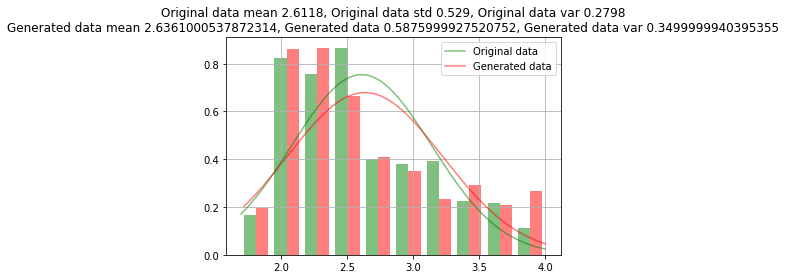

l2_size Normal distribution


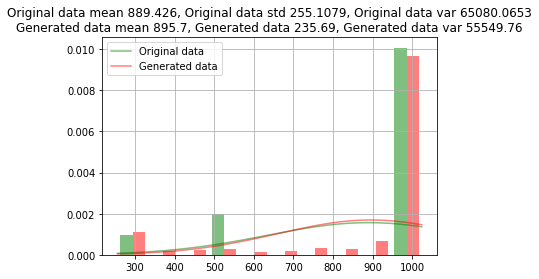

l3_size Normal distribution


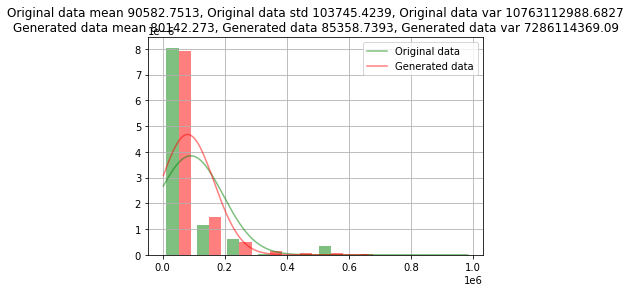

num-cpus Normal distribution


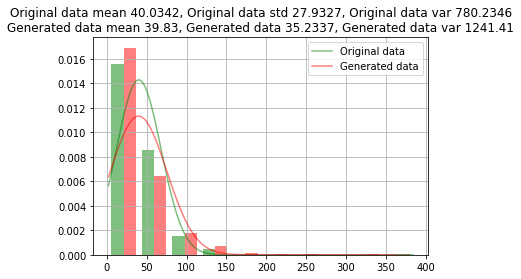

mem_clock Normal distribution


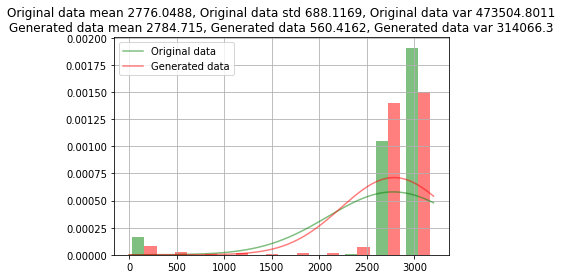

mem_size Normal distribution


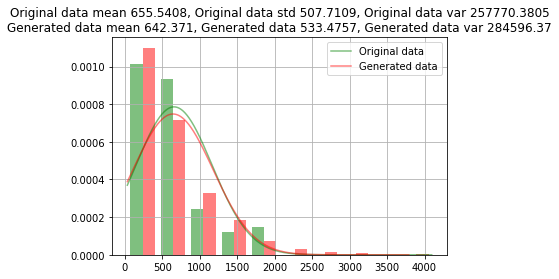

In [ ]:
for column in gen_df.columns:
    print(column, "Normal distribution")
    normal_distribution(data[column], gen_df[column])

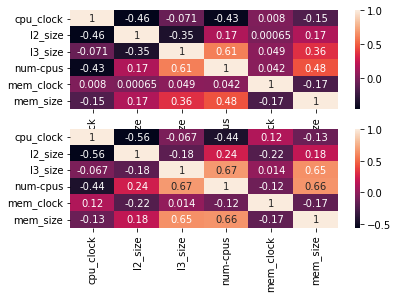

<Figure size 360x360 with 0 Axes>

In [ ]:
#correlation matrix compareing
fig, ax = plt.subplots(2,1)
sns.heatmap(data.corr(), annot = True,ax=ax[0])
sns.heatmap(gen_df.corr(), annot = True,ax=ax[1])
plt.figure(figsize=(5, 5))
plt.show()

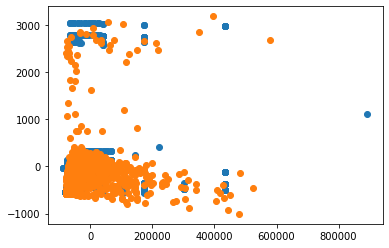

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pcadata = pca.fit_transform(data)
pcanew = pca.fit_transform(gen_df)
plt.scatter(pcadata[:, 0], pcadata[:, 1])
plt.scatter(pcanew[:, 0], pcanew[:, 1])